In [10]:
# initial setup
import polars as pl
import polars.selectors as cs
import sklearn 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config
import matplotlib.pyplot as plt
import pandas as pd
set_config(transform_output='polars')

import warnings
warnings.filterwarnings('ignore')

In [11]:
# load the dataset
raw = pl.read_csv("/home/carlos/projects/ai/bmw.xls")
raw

model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
str,i64,i64,str,i64,str,i64,f64,f64
""" 5 Series""",2014,11200,"""Automatic""",67068,"""Diesel""",125,57.6,2.0
""" 6 Series""",2018,27000,"""Automatic""",14827,"""Petrol""",145,42.8,2.0
""" 5 Series""",2016,16000,"""Automatic""",62794,"""Diesel""",160,51.4,3.0
""" 1 Series""",2017,12750,"""Automatic""",26676,"""Diesel""",145,72.4,1.5
""" 7 Series""",2014,14500,"""Automatic""",39554,"""Diesel""",160,50.4,3.0
…,…,…,…,…,…,…,…,…
""" X3""",2016,19000,"""Automatic""",40818,"""Diesel""",150,54.3,2.0
""" 5 Series""",2016,14600,"""Automatic""",42947,"""Diesel""",125,60.1,2.0
""" 3 Series""",2017,13100,"""Manual""",25468,"""Petrol""",200,42.8,2.0


In [12]:
# pre-process to cast columns to correct type

def preprocess(df):
    return df.with_columns(
        model=pl.col('model').cast(pl.Categorical), 
        year=pl.col('year').cast(pl.String).cast(pl.Categorical),
        transmission=pl.col('transmission').cast(pl.Categorical),
        fuelType=pl.col('fuelType').cast(pl.Categorical))

preprocess(raw)

model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
cat,cat,i64,cat,i64,cat,i64,f64,f64
""" 5 Series""","""2014""",11200,"""Automatic""",67068,"""Diesel""",125,57.6,2.0
""" 6 Series""","""2018""",27000,"""Automatic""",14827,"""Petrol""",145,42.8,2.0
""" 5 Series""","""2016""",16000,"""Automatic""",62794,"""Diesel""",160,51.4,3.0
""" 1 Series""","""2017""",12750,"""Automatic""",26676,"""Diesel""",145,72.4,1.5
""" 7 Series""","""2014""",14500,"""Automatic""",39554,"""Diesel""",160,50.4,3.0
…,…,…,…,…,…,…,…,…
""" X3""","""2016""",19000,"""Automatic""",40818,"""Diesel""",150,54.3,2.0
""" 5 Series""","""2016""",14600,"""Automatic""",42947,"""Diesel""",125,60.1,2.0
""" 3 Series""","""2017""",13100,"""Manual""",25468,"""Petrol""",200,42.8,2.0


# Data Processing

In [26]:
# print(preprocess(raw).select(cs.categorical()).columns)
# print(preprocess(raw).select(cs.numeric()).columns)
pre_transformer = FunctionTransformer(preprocess)

numeric_features = preprocess(raw.drop('price')).select(cs.numeric()).columns
cat_features = preprocess(raw).select(cs.categorical()).columns

num_pipeline = Pipeline([
    ('std', StandardScaler())
])

#num_pipeline.fit_transform(preprocess(raw).select(numeric_features))

cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

#cat_pipeline.fit_transform(preprocess(raw).select(cat_features))

ct = ColumnTransformer(transformers=[
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, cat_features)
])

ct.fit_transform(preprocess(raw).select([*numeric_features, *cat_features]))

x = raw.drop('price')
y = raw.select('price')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Decision Tree Regressor

In [14]:
from sklearn.tree import DecisionTreeRegressor




dt = DecisionTreeRegressor(max_depth=15)

pipe = Pipeline([
    ('pre', pre_transformer),
    ('ct', ct),
    ('model', dt)
])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9141939110333964

In [15]:
pipe

Pipeline(steps=[('pre',
                 FunctionTransformer(func=<function preprocess at 0x7743aeff2830>)),
                ('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  ['mileage', 'tax', 'mpg',
                                                   'engineSize']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['model', 'year',
                                                   'transmission',
                                                   'fuelType'])])),
                ('model', DecisionTreeRegressor(max_depth=15))])

[Text(0.5171958842987602, 0.96875, 'x[0] <= -0.498\nsquared_error = 130528476.402\nsamples = 8624\nvalue = 22669.159'),
 Text(0.2800610309250433, 0.90625, 'x[3] <= 0.615\nsquared_error = 131082902.325\nsamples = 3709\nvalue = 30839.178'),
 Text(0.39862845761190174, 0.9375, 'True  '),
 Text(0.16095184704539395, 0.84375, 'x[3] <= -0.659\nsquared_error = 38066316.4\nsamples = 2824\nvalue = 26470.431'),
 Text(0.09102067640981203, 0.78125, 'x[27] <= 0.5\nsquared_error = 39981926.031\nsamples = 596\nvalue = 21344.025'),
 Text(0.06912307525663244, 0.71875, 'x[0] <= -0.735\nsquared_error = 14633385.003\nsamples = 588\nvalue = 20761.811'),
 Text(0.04585846887081722, 0.65625, 'x[2] <= -0.118\nsquared_error = 10623905.995\nsamples = 400\nvalue = 22163.948'),
 Text(0.03383298893480869, 0.59375, 'x[50] <= 0.5\nsquared_error = 8331951.894\nsamples = 315\nvalue = 22790.66'),
 Text(0.024471737101719772, 0.53125, 'x[52] <= 0.5\nsquared_error = 7417086.946\nsamples = 301\nvalue = 23006.797'),
 Text(0.01

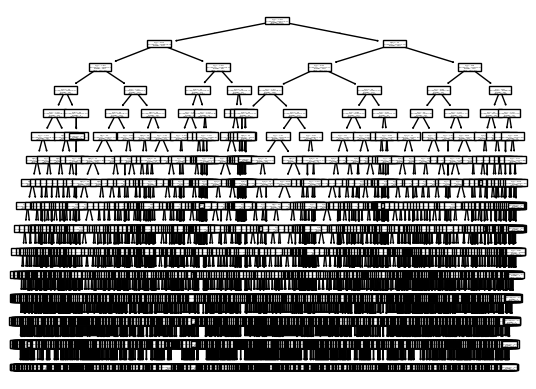

In [16]:
from sklearn.tree import plot_tree
from sklearn import tree

tree.plot_tree(dt)

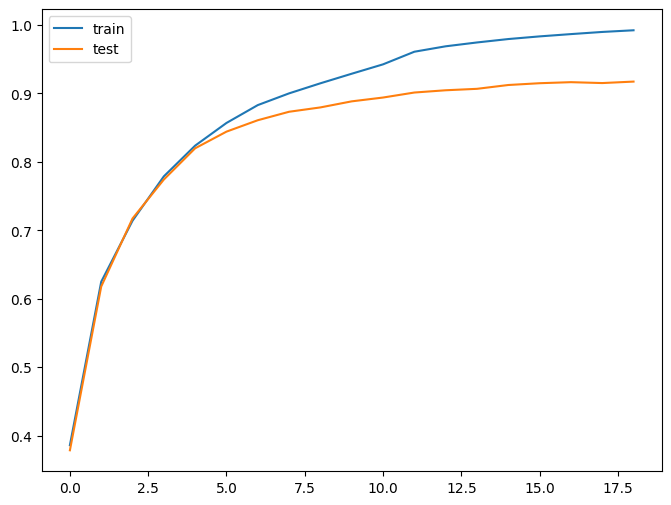

In [ ]:
# loop over various values of max_depth and check the score

trainScores = []
testScores = []

for i in range(1,20):

    dt = DecisionTreeRegressor(max_depth=i)
    pipe = Pipeline([
        ('pre', pre_transformer),
        ('ct', ct),
        ('model', dt)
    ])

    pipe.fit(X_train, y_train)
    
    trainScores.append(pipe.score(X_train, y_train))
    testScores.append(pipe.score(X_test, y_test))

ax = pd.DataFrame({'train': trainScores, 'test': testScores}).plot.line(figsize=(8,6))

In [18]:
pipe.predict(X_test)

array([15899.        , 11013.7       , 41925.79487179, ...,
       22480.        , 54990.        , 45400.        ], shape=(2157,))

In [19]:
y_test.head(8)

price
i64
15300
15495
39875
21730
13799
24499
42202
32400


In [20]:
pipe.predict(X_test.head(8))

array([15899.        , 11013.7       , 41925.79487179, 25500.        ,
       17480.        , 26520.        , 43990.        , 33164.66666667])

# Random Forest Regressor

The idea behind a random forest is to do something similar as a decision tree and apply a few tricks. One of them is to select a subset of columns and do a decision tree based on that subset. Then all of those trees will be combined and choose the best. That is called a random forest.

In [21]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=13)

pipe = Pipeline([
        ('pre', pre_transformer),
        ('ct', ct),
        ('model', rf)
])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9323918187329118

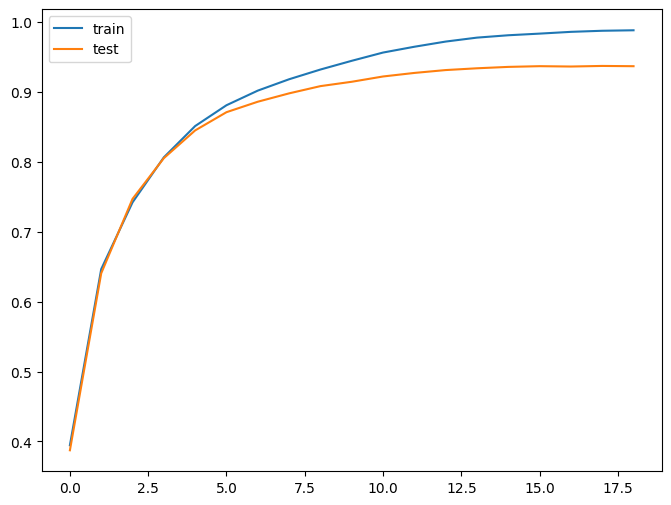

In [22]:
trainScores = []
testScores = []

for i in range(1,20):

    rf = RandomForestRegressor(n_estimators=100, max_depth=i)
    pipe = Pipeline([
        ('pre', pre_transformer),
        ('ct', ct),
        ('model', rf)
    ])

    pipe.fit(X_train, y_train)
    
    trainScores.append(pipe.score(X_train, y_train))
    testScores.append(pipe.score(X_test, y_test))

ax = pd.DataFrame({'train': trainScores, 'test': testScores}).plot.line(figsize=(8,6))

# XGBoost


In [27]:
from xgboost import XGBRegressor

xgb = XGBRegressor()

pipe = Pipeline([
    ('pre', pre_transformer),
    ('ct', ct),
    ('model', xgb)
])

pipe.fit(X_train, y_train)
#pipe.score(X_test, y_test)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

Pipeline(steps=[('pre',
                 FunctionTransformer(func=<function preprocess at 0x7743aeff2830>)),
                ('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  ['mileage', 'tax', 'mpg',
                                                   'engineSize']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['model', 'year',
                                                   'transmission',
                            